In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from astropy.io import fits

import scipy.stats as stats
from astropy.stats import sigma_clip
from scipy.signal import find_peaks

from astropy.visualization import SqrtStretch, ZScaleInterval, SinhStretch, LinearStretch, LogStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import matplotlib.colors
import matplotlib.cm as cm
from matplotlib.patches import Rectangle

In [29]:
h_alpha = 656.28 #nm

In [2]:
def pixel_to_wavelengths(N, pfit):
    
    pxl_axis = np.arange(0, N)
    wavelengths = pfit[0]*pxl_axis**2 + pfit[1]*pxl_axis + pfit[2]
    
    return wavelengths


def median_frames(folder, filenames, shape=(2048, 2048)):

    cube = np.zeros((len(filenames), shape[0], shape[1]))

    for i, f in enumerate(filenames):

        hdul = fits.open(f'{folder}/{f}.fits')
        cube[i, :, :] = hdul[0].data
        hdul.close()

    cube_med = np.median(cube, axis=0)

    return cube_med


def median_frames_itime(folder, filenames, shape=(2048, 2048)):

    cube = np.zeros((len(filenames), shape[0], shape[1]))

    for i, f in enumerate(filenames):

        hdul = fits.open(f'{folder}/{f}.fits')
        
        itime = hdul[0].header['EXPTIME']
        cube[i, :, :] = hdul[0].data / itime
        
        hdul.close()

    cube_med = np.median(cube, axis=0)

    return cube_med

### Housekeeping

In [3]:
folder = '/Users/isabelkain/Downloads/UGC11876'
filelist = glob.glob(f'{folder}/*.fits')

## Generate list of filenames

fnames = np.array([])
fpaths = np.array([])

for f in filelist:
    txt = f.split('/')[-1].split('.')[0]  # reduce full path to just file name (w/out extension)
    fnames = np.append(fnames, txt)
    fpaths = np.append(fpaths, f[:-11])

## List of filetypes (e.g. bias, flat, science, etc)

ftypes = np.array([])

for f in filelist:

    hdul = fits.open(f)
    tag = hdul[0].header['OBJECT']
    hdul.close()

    ftypes = np.append(ftypes, tag)

## Zip filenames and types into pandas DF

filedict = pd.DataFrame(np.array([fpaths, fnames, ftypes]).T, columns=['Path', 'Filename', 'Target'])
filedict.sort_values(by='Filename', inplace=True, ignore_index=True)
filedict

,Path,Filename,Target
0,/Users/isabelkain/Downloads/UGC11876,r1050,ArcFlat
1,/Users/isabelkain/Downloads/UGC11876,r1051,ArcFlat
2,/Users/isabelkain/Downloads/UGC11876,r1052,ArcFlat
3,/Users/isabelkain/Downloads/UGC11876,r1053,ArcFlat
4,/Users/isabelkain/Downloads/UGC11876,r1054,ArcFlat
5,/Users/isabelkain/Downloads/UGC11876,r1055,DomeFlat
6,/Users/isabelkain/Downloads/UGC11876,r1056,DomeFlat
7,/Users/isabelkain/Downloads/UGC11876,r1057,DomeFlat
8,/Users/isabelkain/Downloads/UGC11876,r1058,DomeFlat
9,/Users/isabelkain/Downloads/UGC11876,r1059,DomeFlat


In [4]:
sci_ix = (filedict['Target']=='Science')
bias_ix = (filedict['Target']=='Bias')
flat_ix = (filedict['Target']=='DomeFlat')
arc_ix = (filedict['Target']=='ArcFlat')

###  Pixel calibration

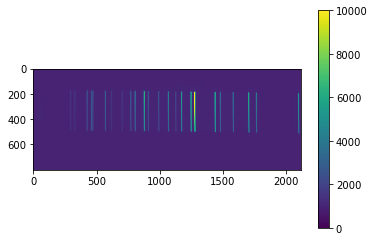

In [65]:
fnames = filedict[arc_ix]['Filename'].array
fpaths = filedict[arc_ix]['Path'].array

arc_img = median_frames(fpaths[0], fnames, shape=(2120,800))

plt.imshow(arc_img.T, vmin=0, vmax=10000)
plt.colorbar()

(0.0, 2130.0)

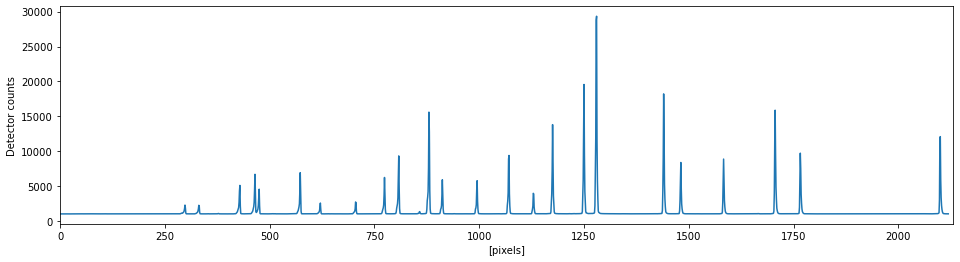

In [6]:
arc_spectrum = arc_img[:, 300]

plt.figure(figsize=(16,4))
plt.plot(arc_spectrum)

plt.ylabel('Detector counts')
plt.xlabel('[pixels]')
plt.xlim(0, len(arc_spectrum)+10)

(0.0, 2130.0)

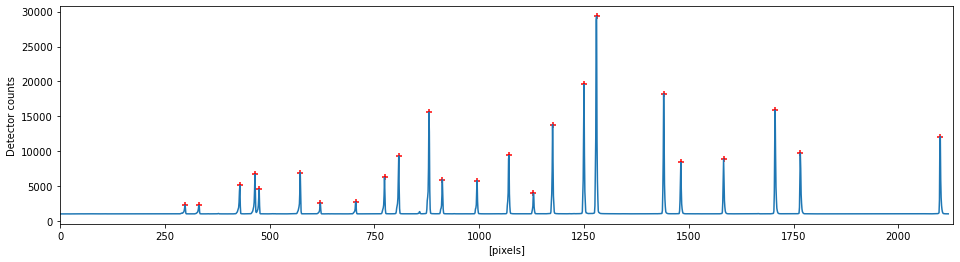

In [7]:
peak_indices, __ = find_peaks(arc_spectrum, prominence=80, height=2000)

plt.figure(figsize=(16,4))
plt.plot(arc_spectrum)
plt.scatter(peak_indices, arc_spectrum[peak_indices], marker='+', color='r')

plt.ylabel('Detector counts')
plt.xlabel('[pixels]')
plt.xlim(0, len(arc_spectrum)+10)

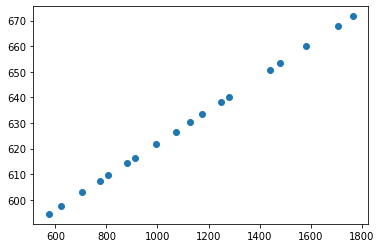

In [69]:
## Comparing to Kast red 1200/5000: 
## https://mthamilton.ucolick.org/techdocs/instruments/kast/images/Kastred1200Ne6000A.jpg

wvl = {'h':594.483,
       'i':597.528,
       'j':603.000,
       'k':607.434,
       'l':609.616,
       'm':614.306,
       'n':616.359,
       'o':621.728,
       'p':626.650,
       'q':630.479,
       'r':633.440,
       's':638.299,
       't':640.225,
       'u':650.653,
       'v':653.288,
       'w':659.895,
       'x':667.820,
       'y':671.704,
#        'a':340.365,
#        'b':346.655,
#        'c':361.051,
#        'd':365.015,
#        'e':366.288,
        }

# a = peak_indices[0]
# b = peak_indices[1]
# c = peak_indices[2]
# d = peak_indices[3]
# e = peak_indices[4]
h = peak_indices[5]
i = peak_indices[6]
j = peak_indices[7]
k = peak_indices[8]
l = peak_indices[9]
m = peak_indices[10]
n = peak_indices[11]
o = peak_indices[12]
p = peak_indices[13]
q = peak_indices[14]
r = peak_indices[15]
s = peak_indices[16]
t = peak_indices[17]
u = peak_indices[18]
v = peak_indices[19]
w = peak_indices[20]
x = peak_indices[21]
y = peak_indices[22]
# z = ??? not on lamp calibration plot

indices = np.array([h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y])
wvl_vals = np.array(list(wvl.values()))


plt.scatter(indices, wvl_vals)

[3.93714224e-08 6.47079227e-02 5.57340451e+02]


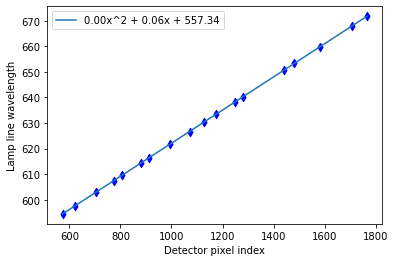

In [68]:
## Fit curve to px/nm plot

pfit = np.polyfit(indices, wvl_vals, 2)
x = np.linspace(np.min(indices), np.max(indices), len(indices))

print(p)

plt.plot(x, pfit[0]*x**2 + pfit[1]*x + pfit[2], label=f'{pfit[0]:0.2f}x^2 + {pfit[1]:0.2f}x + {pfit[2]:0.2f}')
plt.scatter(indices, wvl.values(), marker='d', color='b')
plt.xlabel('Detector pixel index')
plt.ylabel('Lamp line wavelength')

plt.legend()

In [118]:
## Apply pixel solution, create wavelength axis

wavelengths = pixel_to_wavelengths(len(arc_spectrum), pfit)
print(wavelengths[0], wavelengths[-1])

557.3404511322955 694.6333233791331


Text(0.5, 1.0, 'Arc lamp spectrum\nNeon, Hg-Ar, He')

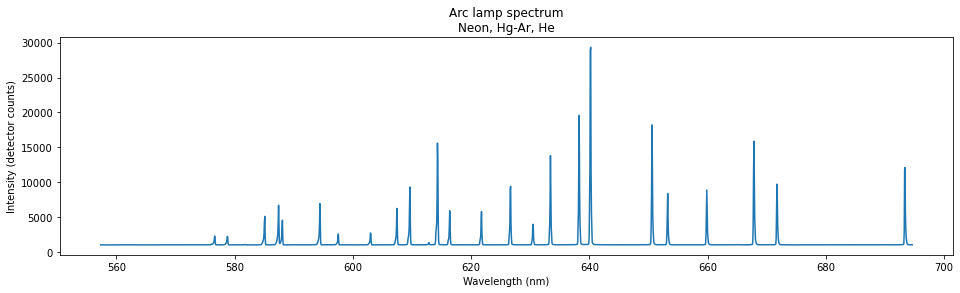

In [11]:
plt.figure(figsize=(16,4))
plt.plot(wavelengths, arc_spectrum)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (detector counts)')
plt.title('Arc lamp spectrum\nNeon, Hg-Ar, He')

In [72]:
wavelengths[peak_indices[20]]

659.8717531957643

### Image calibration

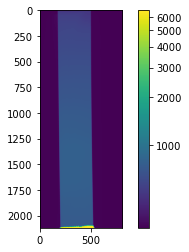

In [73]:
## Read in flats

fnames = filedict[flat_ix]['Filename'].array
fpaths = filedict[flat_ix]['Path'].array

flat = median_frames(fpaths[0], fnames, shape=(2120, 800)) / 10.

norm = ImageNormalize(interval=ZScaleInterval(contrast=1.), stretch=AsinhStretch())
plt.imshow(flat, norm=norm)
plt.colorbar()

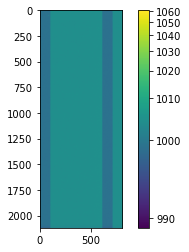

In [74]:
## Read in bias

fnames = filedict[bias_ix]['Filename'].array
fpaths = filedict[bias_ix]['Path'].array

bias = median_frames(fpaths[0], fnames, shape=(2120, 800))

norm = ImageNormalize(interval=ZScaleInterval(contrast=1.), stretch=AsinhStretch())
plt.imshow(bias, norm=norm)
plt.colorbar()

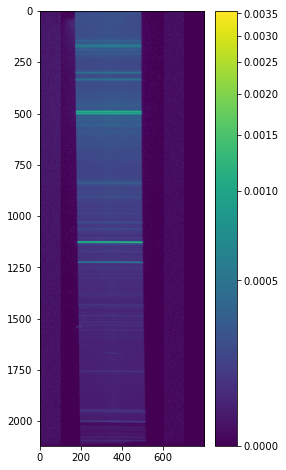

In [75]:
## Read in science frames, calibrate each one independently (different exposure times)

fnames = filedict[sci_ix]['Filename'].array
fpaths = filedict[sci_ix]['Path'].array
sci = np.zeros((len(fnames), 2120, 800))

for i, f in enumerate(fnames):

    hdul = fits.open(f'{fpaths[0]}/{f}.fits')

    itime = hdul[0].header['EXPTIME']
    sci[i, :, :] = (hdul[0].data - bias) / itime

    hdul.close()

science = np.median(sci, axis=0) / flat

## Plot

plt.figure(figsize=(4, 8))
norm = ImageNormalize(interval=ZScaleInterval(contrast=1.), stretch=AsinhStretch(), vmin=0)
plt.imshow(science, norm=norm)
plt.colorbar()

In [77]:
## Write calibrated image

hdu = fits.PrimaryHDU(science)
hdu.writeto('kast_calibrated.fits', overwrite=True)


### Establish dimensions of spectrum

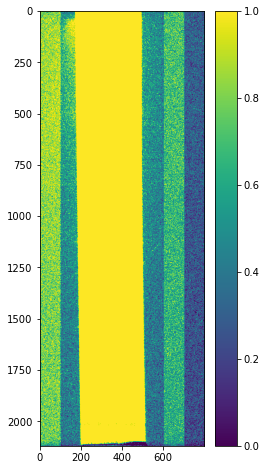

In [84]:
## Find dimensions

spectrum_mask = science >= 0.00001

plt.figure(figsize=(4, 8))
plt.imshow(spectrum_mask)
plt.colorbar()

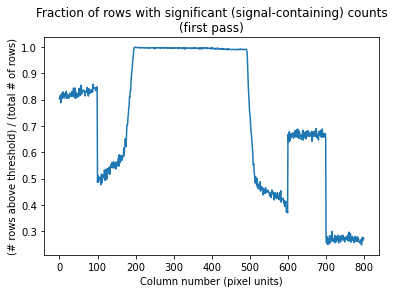

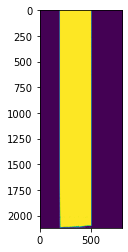

In [85]:
## Establish threshold to eliminate detector bias columns

frac_masked = np.zeros(np.shape(science)[1])

for col in range(np.shape(science)[1]):
    frac_masked[col] = np.sum(spectrum_mask[:,col]) / np.shape(science)[0] 
    
plt.plot(frac_masked)
plt.title('Fraction of rows with significant (signal-containing) counts\n(first pass)')
plt.xlabel('Column number (pixel units)')
plt.ylabel('(# rows above threshold) / (total # of rows)')

spec_cols = frac_masked >= 0.9
spectrum_mask = spectrum_mask & spec_cols

plt.figure()
plt.imshow(spectrum_mask)
    

Text(0, 0.5, '(# rows above threshold) / (total # of rows)')

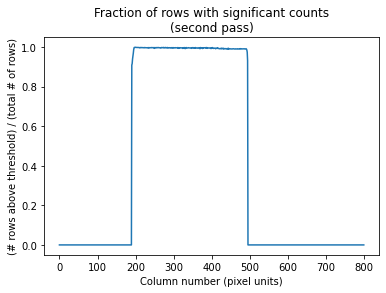

In [86]:
## Check what the fraction masked is after the first cut

frac_masked_post = np.zeros(np.shape(science)[1])

for col in range(np.shape(science)[1]):
    frac_masked_post[col] = np.sum(spectrum_mask[:,col]) / np.shape(science)[0] 

plt.plot(frac_masked_post)
plt.title('Fraction of rows with significant counts\n(second pass)')
plt.xlabel('Column number (pixel units)')
plt.ylabel('(# rows above threshold) / (total # of rows)')


Median spectrum width: 305
Width check: 305 304
Center column spectrum: 342


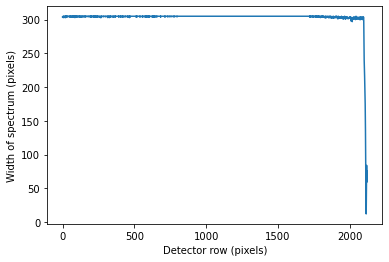

In [87]:
## Identify the center of the spectrum (which is tilted WRT pixels)

# Find width
specmask_sum = np.sum(spectrum_mask, axis=1)
plt.plot(specmask_sum)
plt.ylabel('Width of spectrum (pixels)')
plt.xlabel('Detector row (pixels)')

spectrum_width_px = int( np.median(specmask_sum) )
print('Median spectrum width:', spectrum_width_px)

spectrum_left_px = np.where(frac_masked_post>0.8)[0][0]
spectrum_right_px = np.where(frac_masked_post>0.8)[0][-1]

print( 'Width check:', spectrum_width_px, spectrum_right_px-spectrum_left_px )

spectrum_center_px = spectrum_left_px + (spectrum_width_px // 2)
print('Center column spectrum:', spectrum_center_px)

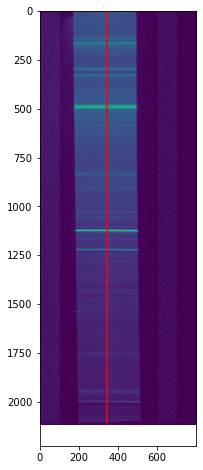

In [88]:
## Visually check that the center column is indeed in the center

plt.figure(figsize=(4,8))
norm = ImageNormalize(interval=ZScaleInterval(contrast=1.), stretch=AsinhStretch(), vmin=0)
plt.imshow(science, norm=norm)
plt.vlines(spectrum_center_px, 0, np.shape(science)[0], color='r')

Text(0.5, 1.0, 'Spectrum\nPost-reduction\nPre-sky subtraction')

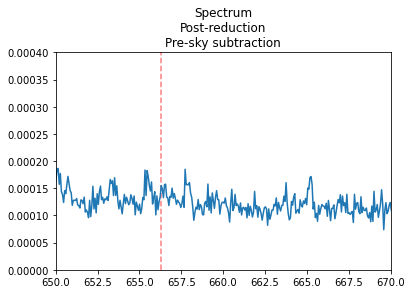

In [89]:
## Take cross-section of spectrum along central column

centr_spectrum = science[:, spectrum_center_px]
plt.plot(wavelengths, centr_spectrum)
plt.xlim(650, 670)
plt.ylim(0., 0.0004)

plt.vlines(h_alpha, 0., 0.0004, ls='--', color='r', alpha=0.5, label=r'$H_\alpha$')

plt.title('Spectrum\nPost-reduction\nPre-sky subtraction')

(0.0, 0.0005)

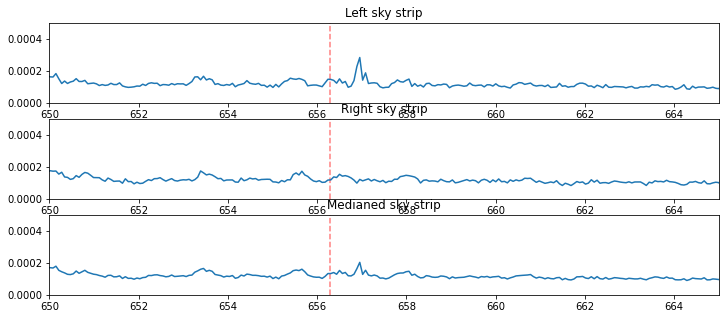

In [90]:
## Test: subtract strip along edge to do sky subtraction

# Take 5px strip along rightmost, leftmost side of spectrum and median them
# (sky signatures stretch across entire spectrum, H_alpha is a smudge in the middle)
sky_strip_l = np.median(science[:, spectrum_left_px + 5:spectrum_left_px + 10], axis=1)
sky_strip_r = np.median(science[:, spectrum_right_px - 10:spectrum_right_px - 5], axis=1)

sky_strip = np.median((sky_strip_l, sky_strip_r), axis=0)

## Plot sky strips

fig, ax = plt.subplots(3, 1, figsize=(12, 5))
ax[0].plot(wavelengths, sky_strip_l.T)
ax[1].plot(wavelengths, sky_strip_r.T)
ax[2].plot(wavelengths, sky_strip.T)

ax[0].set_title('Left sky strip')
ax[1].set_title('Right sky strip')
ax[2].set_title('Medianed sky strip')

ax[0].vlines(h_alpha, 0., 0.0005, ls='--', color='r', alpha=0.5, label=r'$H_\alpha$')
ax[1].vlines(h_alpha, 0., 0.0005, ls='--', color='r', alpha=0.5, label=r'$H_\alpha$')
ax[2].vlines(h_alpha, 0., 0.0005, ls='--', color='r', alpha=0.5, label=r'$H_\alpha$')

ax[0].set_xlim(650,665)
ax[1].set_xlim(650,665)
ax[2].set_xlim(650,665)
ax[0].set_ylim(0.,0.0005)
ax[1].set_ylim(0.,0.0005)
ax[2].set_ylim(0.,0.0005)


In [41]:
## Based on prev. cell, right sky strip is the best to use for subtracting sky in this wavelength region

sky_strip = np.copy(sky_strip_r)

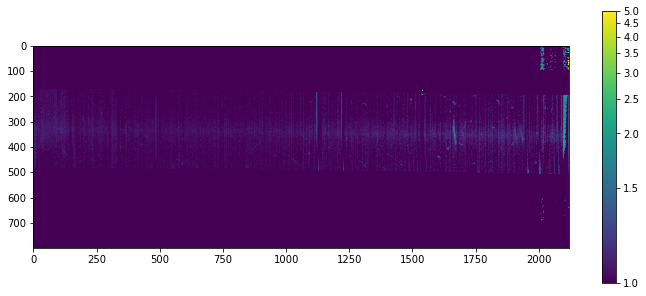

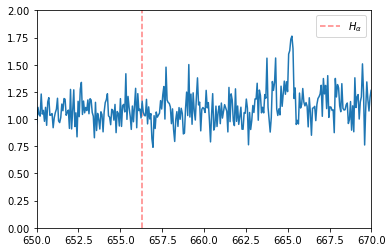

In [91]:
## Remove sky_strip from each col in calibrated science image

science_skysub = np.zeros(np.shape(science))

for col in range(np.shape(science)[1]):
    science_skysub[:,col] = science[:,col] / sky_strip

    
## Plot sky-subtracted science spectrum    

# norm = ImageNormalize(interval=ZScaleInterval(contrast=1.), stretch=AsinhStretch(), vmin=0, vmax=.0005) # -
norm = ImageNormalize(interval=ZScaleInterval(contrast=1.), stretch=AsinhStretch(), vmin=1, vmax=5)     # /

plt.figure(figsize=(12,5))
plt.imshow(science_skysub.T, norm=norm)
plt.colorbar()

plt.figure()
plt.plot(wavelengths, science_skysub[:,spectrum_center_px])
# plt.vlines(h_alpha, 0, 0.0005, ls='--', color='r', alpha=0.5, label=r'$H_\alpha$')  # -
plt.vlines(h_alpha, 0, 2, ls='--', color='r', alpha=0.5, label=r'$H_\alpha$') # /

plt.xlim(650,670)
# plt.ylim(-0.0001, 0.0005)  # - 
plt.ylim(0, 2)              # /
plt.legend()

Text(0.5, 1.0, 'Calibrated, no sky subtraction')

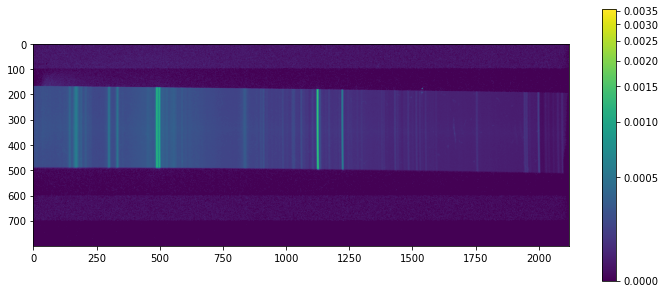

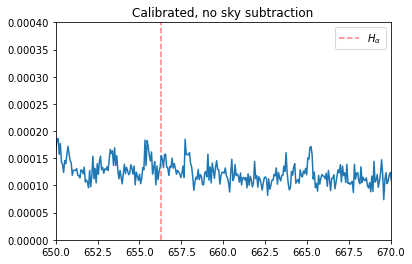

In [93]:
## Compare to not subtracting sky:

plt.figure(figsize=(12,5))
norm = ImageNormalize(interval=ZScaleInterval(contrast=1.), stretch=AsinhStretch(), vmin=0)
plt.imshow(science.T, norm=norm)
plt.colorbar()

plt.figure()
plt.plot(wavelengths, science[:,spectrum_center_px])
plt.vlines(h_alpha, 0, 0.0004, ls='--', color='r', alpha=0.5, label=r'$H_\alpha$') # /
plt.xlim(650, 670)
plt.ylim(0., 0.0004)
plt.legend()

plt.title('Calibrated, no sky subtraction')

Text(0.5, 1.0, 'Partially calibrated (no flats), no sky subtraction')

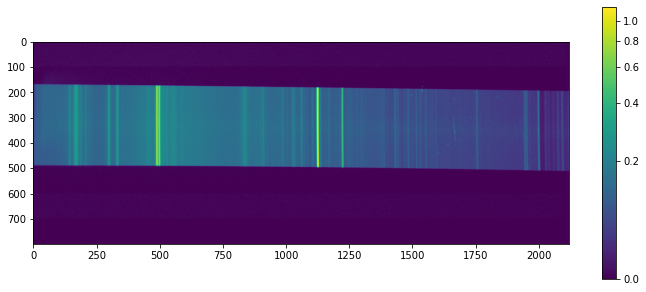

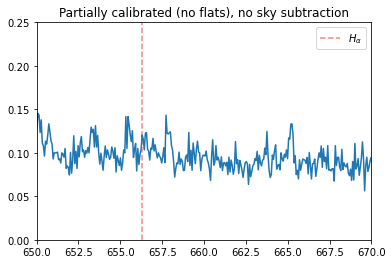

In [94]:
## Compare to un-calibrated, no-sky subtraction image

np.median(sci, axis=0)

plt.figure(figsize=(12,5))
norm = ImageNormalize(interval=ZScaleInterval(contrast=1.), stretch=AsinhStretch(), vmin=0)
plt.imshow(np.median(sci, axis=0).T, norm=norm)
plt.colorbar()

plt.figure()
plt.plot(wavelengths, np.median(sci, axis=0)[:,spectrum_center_px])
plt.vlines(h_alpha, 0, 0.25, ls='--', color='r', alpha=0.5, label=r'$H_\alpha$') # /
plt.xlim(650, 670)
plt.ylim(0., 0.25)
plt.legend()

plt.title('Partially calibrated (no flats), no sky subtraction')

In [95]:
# Conclusion: calibrating and removing sky background is marginally helpful. 

In [96]:
## Save sky-subtracted, calibrated image 

hdu = fits.PrimaryHDU(science_skysub)
hdu.writeto('kast_calibrated_skysubtracted.fits', overwrite=True)


#### Summary:

In [ ]:
# spectrum_width_px:   width of spectrum on detector (pixel units)
# spectrum_left_px:    index of rightmost column (pixel units)
# spectrum_right_px:   index of leftmost column (pixel units)
# spectrum_center_px:  index of central column (pixel units)

### Locating $H_\alpha$ signature

In [97]:
loc_h_alpha = np.argmin( np.abs(wavelengths - h_alpha) )
print(loc_h_alpha, wavelengths[loc_h_alpha])

print('Testing window:', wavelengths[loc_h_alpha-50], wavelengths[loc_h_alpha+50])

1528 656.3060807995112
Testing window: 653.0647671392487 659.5475913168857


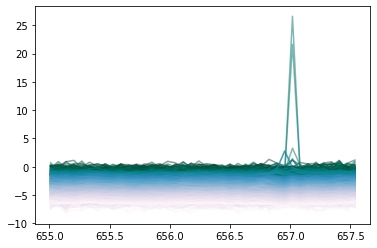

In [98]:
## Read out spectrum slices around Halpha, view results

r = 20 # width of window around known Halpha
slices = np.zeros((spectrum_width_px, r*2))

for col in range(spectrum_width_px):

    sl = science_skysub[:, col]
    slices[col] = sl[loc_h_alpha - r:loc_h_alpha + r]

## plot

norm = matplotlib.colors.Normalize(vmin=0,
                                   vmax=(spectrum_width_px // 2),
                                   clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.PuBuGn_r)

for col in range(spectrum_width_px):

    dist = np.abs((spectrum_width_px // 2) - col)
    plt.plot(wavelengths[loc_h_alpha - r:loc_h_alpha + r],
             slices[col] - dist / 20,
             alpha=0.5,
             color=matplotlib.colors.to_hex(mapper.to_rgba(dist)))

In [99]:
## Median every 2 rows

slices_med = np.zeros((np.shape(slices)[0]//2, r*2))
check = np.full_like(slices, False)

i = 0
j = 0

while i < (np.shape(slices)[0] - 1) :
    
    slices_med[j,:] = np.median((slices[i], slices[i+1]), axis=0)
    
    check[i, :] = True
    check[i+1, :] = True
    
    i += 2
    j += 1
    
print( 'All slices accounted for?', np.all(check), int(np.sum(check, axis=0)[0]), '/', np.shape(slices)[0], 'columns' )

All slices accounted for? False 304 / 305 columns


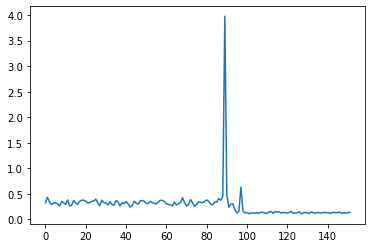

In [100]:
std = []

for i in range(len(slices_med)):
    
    std.append( np.std(slices_med[i]) )
    
plt.plot(std)

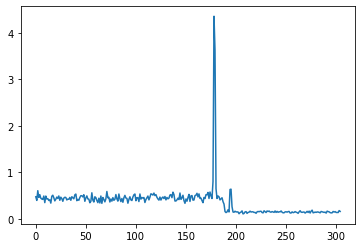

In [101]:
std = []

for i in range(len(slices)):
    
    std.append( np.std(slices[i]) )
    
plt.plot(std)

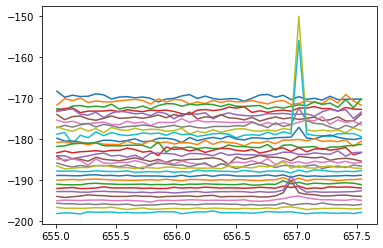

In [102]:
for i in range(170,200):
    
    plt.plot(wavelengths[loc_h_alpha - r:loc_h_alpha + r], slices[i]-(i))

### Testing slicing without reducing

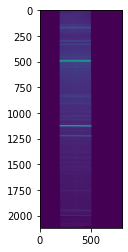

In [410]:
sci_nocal = np.median(sci, axis=0)*spectrum_mask
plt.imshow(sci_nocal)

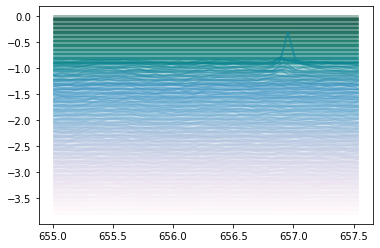

In [412]:
## Read out spectrum slices around Halpha, view results

r = 20 # width of window around known Halpha
slices = np.zeros((spectrum_width_px, r*2))

for col in range(spectrum_width_px):

    sl = sci_nocal[:, col]
    slices[col] = sl[loc_h_alpha - r:loc_h_alpha + r]

## plot

norm = matplotlib.colors.Normalize(vmin=0,
                                   vmax=(spectrum_width_px // 2),
                                   clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.PuBuGn_r)

for col in range(spectrum_width_px):

    dist = np.abs((spectrum_width_px // 2) - col)
    plt.plot(wavelengths[loc_h_alpha - r:loc_h_alpha + r],
             slices[col] - dist / 40,
             alpha=0.5,
             color=matplotlib.colors.to_hex(mapper.to_rgba(dist)))

### Just fucking start over with slicing

In [ ]:
# spectrum_width_px:   width of spectrum on detector (pixel units)
# spectrum_left_px:    index of rightmost column (pixel units)
# spectrum_right_px:   index of leftmost column (pixel units)
# spectrum_center_px:  index of central column (pixel units)

(1625.0, 1725.0)

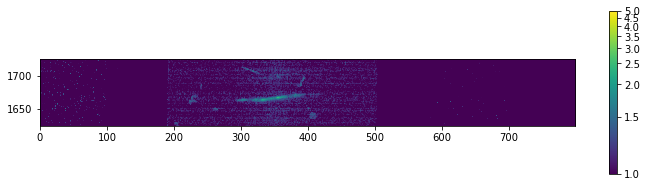

In [114]:
norm = ImageNormalize(interval=ZScaleInterval(contrast=1.), stretch=AsinhStretch(), vmin=1, vmax=5)

plt.figure(figsize=(12,3))
plt.imshow(science_skysub, norm=norm)
plt.colorbar()

px_limits = (1625,1725)
plt.ylim(px_limits)


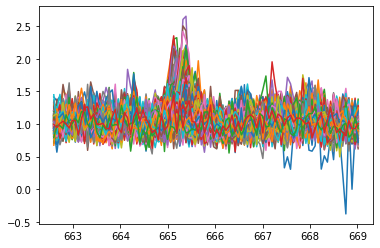

In [269]:
pixel_column = np.array([])
peak_wavelength = np.array([])

for i in range(spectrum_left_px, spectrum_right_px):
    
    crossection = science_skysub[px_limits[0]:px_limits[1], i]
    plt.plot(wavelengths[px_limits[0]:px_limits[1]], crossection)
    
    peaks, __ = find_peaks(crossection, prominence=(0.7, None))
    
    if (len(peaks) == 0) or (len(peaks) > 2):
        continue      
        
#     elif (len(peaks) == 2):
#         peaks = peaks[0] # pick the first one; by eye, the consistent signal is the lower-wavelength peak
        
        
    pixel_column = np.append(pixel_column, i)
    peak_wavelength = np.append(peak_wavelength, wavelengths[px_limits[0]:px_limits[1]][peaks[0]])


[39]


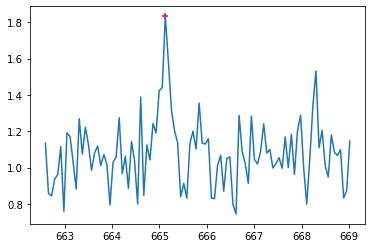

In [260]:
px_col = spectrum_left_px+spectrum_width_px//2-40
crossection = science_skysub[px_limits[0]:px_limits[1], px_col]

plt.plot(wavelengths[px_limits[0]:px_limits[1]], crossection)

peaks, __ = find_peaks(crossection, prominence=(0.7, None))
print(peaks)

plt.scatter(wavelengths[px_limits[0]:px_limits[1]][peaks], crossection[peaks], marker='+', color='r')

/Users/isabelkain/opt/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2825: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


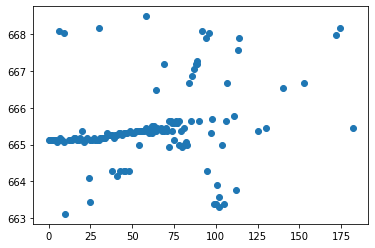

In [254]:
plt.scatter(np.abs(np.array(pixel_column) - spectrum_width_px), peak_wavelength)

In [270]:
peak_wavelength

array([667.91159758, 667.58738688, 664.99377215, 663.56733775,
       665.3179671 , 667.91159758, 665.64216402, 667.26317815,
       664.99377215, 665.05861098, 664.99377215, 664.9289334 ,
       665.38280633, 664.99377215, 665.57732448, 665.12344989,
       665.38280633, 664.9289334 , 667.19833664, 666.48508522,
       665.3179671 , 665.38280633, 668.4951818 , 664.99377215,
       664.28055019, 664.28055019, 664.28055019, 664.15087449,
       664.28055019, 668.17096755, 663.43766379, 663.11348026,
       665.05861098, 665.12344989, 665.12344989, 665.12344989,
       665.05861098, 665.12344989, 665.12344989, 665.12344989,
       665.12344989, 665.12344989, 665.12344989, 665.12344989,
       665.12344989, 665.12344989, 668.10612494, 665.18828889,
       668.04128241, 665.12344989, 665.12344989, 665.12344989,
       665.18828889, 665.18828889, 665.12344989, 665.12344989,
       665.18828889, 665.38280633, 665.05861098, 665.12344989,
       665.18828889, 664.08603676, 665.12344989, 665.12

Text(0.5, 1.0, 'Peak wavelength histogram')

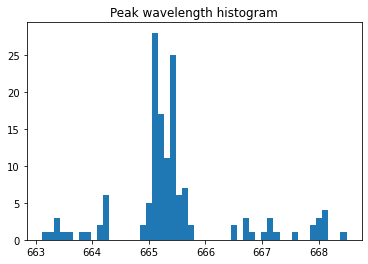

In [280]:
plt.hist(peak_wavelength, bins=50);
plt.title('Peak wavelength histogram')

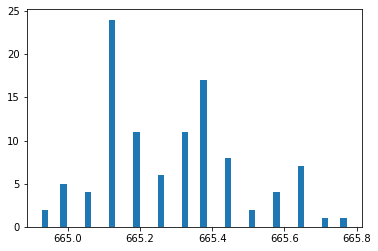

In [281]:
trim_wvl = (peak_wavelength > 664.5) & (peak_wavelength < 666.4)
peak_wavelength_trim = peak_wavelength[trim_wvl]
pixel_column_trim = pixel_column[trim_wvl]

plt.hist(peak_wavelength_trim, bins=50);

(654.0, 670.0)

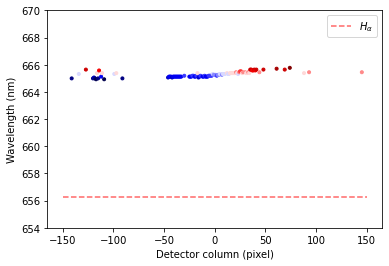

In [293]:
plt.hlines(h_alpha, -150, 150, ls='--', color='r', alpha=0.6, label=r'$H_\alpha$')
plt.legend()

plt.scatter((pixel_column_trim - spectrum_center_px), 
            peak_wavelength_trim, 
            marker='.', c=peak_wavelength_trim, cmap='seismic')

plt.xlabel('Detector column (pixel)')
plt.ylabel('Wavelength (nm)')
plt.ylim(654, 670)

Text(0.5, 1.0, 'Shift of $H_\\alpha$ line')

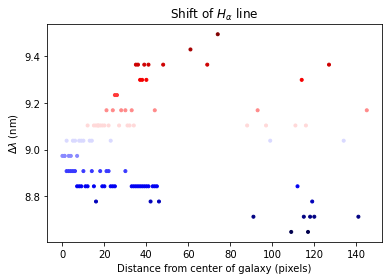

In [300]:
plt.scatter(np.abs(pixel_column_trim - spectrum_center_px), 
            peak_wavelength_trim - h_alpha, 
            marker='.', c=peak_wavelength_trim, cmap='seismic')

plt.xlabel('Distance from center of galaxy (pixels)')
plt.ylabel(r'$\Delta\lambda$ (nm)')
# plt.ylim(654, 670)
plt.title(r'Shift of $H_\alpha$ line')